In [1]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
import numpy as np
import InputShaping as shaping
%matplotlib inline

N = me.ReferenceFrame('N')
B = me.ReferenceFrame('B')

x, theta, f, S = me.dynamicsymbols('x theta f S')
x_dot, theta_dot = me.dynamicsymbols('x_dot theta_dot')
L, M, m, t = sympy.symbols('L M m t')

B.orient(N, 'Axis', (theta, N.z))
B.set_ang_vel(N, theta_dot * N.z)

In [2]:
O1 = me.Point('O1')
G = me.Point('G')
P = me.Point('P')
O1.set_vel(N, 0)
G.set_pos(O1, x * N.x)
G.set_vel(N, x_dot * N.x)
P.set_pos(G, -L * B.y)
P.v2pt_theory(G,N,B)
kde = [x_dot - x.diff(t), theta_dot - theta.diff(t)]
Pen_length = 1

In [3]:
p_grav = (P, -m * 9.81 * N.y)
p_cart = (P, m * 9.81 * B.y)
cart_p = (G, -m * 9.81 * B.y)
force = (G, f * N.x)
shape_fo = (G, S * N.x)

pendulum = me.Particle('pendulum', P, m)
cart = me.Particle('cart', G, M)

In [4]:
coordinates = [x, theta]
speeds= [x_dot, theta_dot]
kane = me.KanesMethod(N, coordinates, speeds, kde)

# loads = [spring_1_force_P1, spring_2_force_P2, grav_force]
loads = [p_grav, p_cart, cart_p, force, shape_fo]

fr, frstar = kane.kanes_equations(loads, [cart, pendulum])

Mass = kane.mass_matrix_full
full = kane.forcing_full

In [5]:
example_shaper = shaping.ZV(3.132091953, 0.0)
Shaper = example_shaper.shaper
shaped_s_curve = shaping.shaped_input(shaping.s_curve, t, Shaper,3,2,1)

In [6]:
def bang(Amps, Times, Interval, t):
    '''
    This function will issue impulses at the times given
    '''
    n = np.size(Amps)
    F = []
    for i in range(n):
        Fi = Amps[i]
        Ti = Times[i]
        fi = Fi * (t >= Ti) * (t <= Ti + Interval)
        F.append(fi)
    f = sum(F)
    return f

In [7]:
sys = System(kane)
sys.constants = {m:0.10,
                 M:10.0,
                 L:Pen_length}
sys.initial_conditions = {x:0, theta:0, x_dot:0, theta_dot:0}

# sys.specifieds={f:lambda x, t:bang([20,20,28.35], [0,0.5,1.253],0.5,t)}
# sys.specifieds={f:lambda x, t:shaping.shaped_input(shaping.s_curve, t, Shaper,30,2,1)}

# sys.specifieds={f:lambda x, t:richard(t, 20, 1, 0.1, 2, 0, 20)}
sys.times = np.linspace(0.0, 40.0, 1000)
resp = sys.integrate()

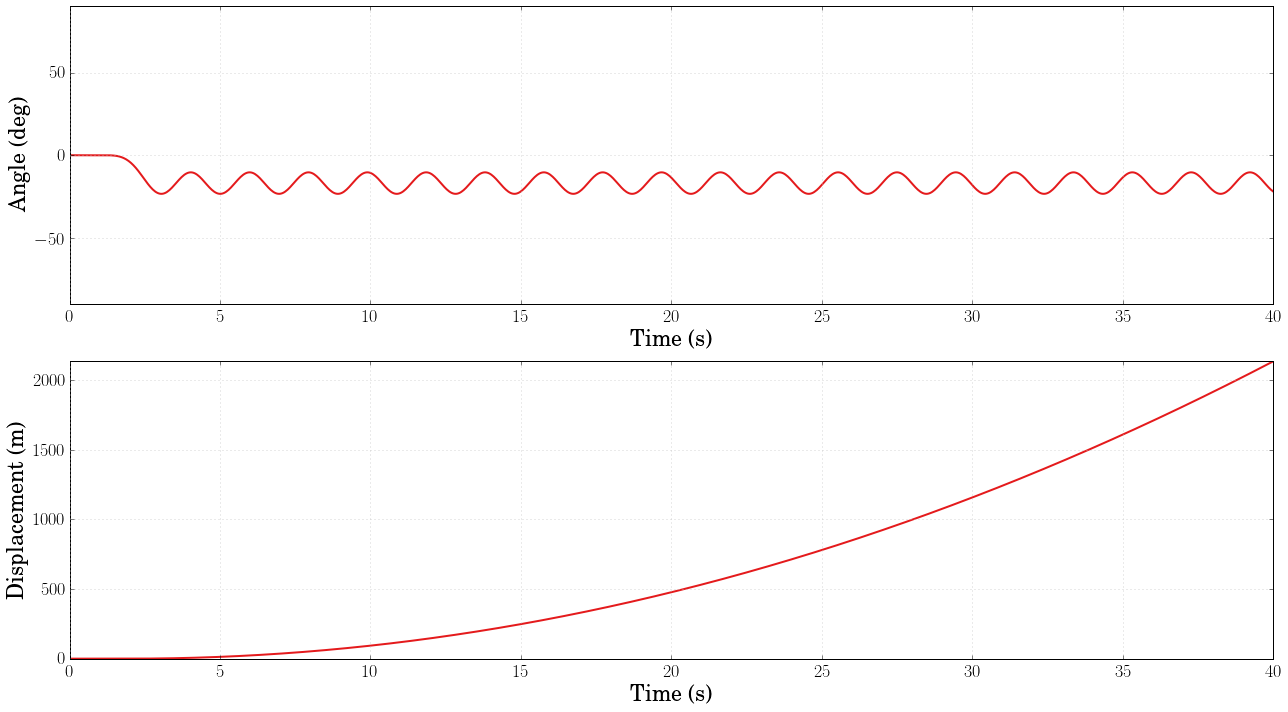

In [8]:
sim_time = np.linspace(0.0, 40.0, 1000)
fig = plt.figure(figsize=(18, 10))

# fig = plt.figure(0)
# fig.add_subplot(321)
# plt.plot(sim_time, bang([20,20,28.35], [0,0.5,1.253],0.25,sim_time))
# plt.plot(sim_time, richard(sim_time, 20, 5, 0.1, 2, 0, 10))
# plt.xlabel(r'Time (s)')
# plt.ylabel(r'Force (N)')
# plt.ylim(-F_max1 - 12, F_max1 + 15)
# plt.xlim(0,5)
# plt.title(r'Force Exerted')

# fig.add_subplot(311)
# plt.plot(sim_time, resp[:,2], label='Unshaped')
# plt.ylim(np.min(resp[:,2]-2),np.max(resp[:,2]+2))
# plt.xlabel(r'Time (s)')
# plt.ylabel(r'Velocity ($\frac{m}{s}$)')
# plt.title(r'X Motion')

fig.add_subplot(211)
plt.plot(sim_time, np.degrees(resp[:,1]), label='Unshaped')
plt.xlabel(r'Time (s)')
plt.ylabel(r'Angle (deg)')
plt.ylim(-90,90)
# plt.title(r'$\theta$ Motion')

# fig.add_subplot(324)
# plt.plot(sim_time, np.degrees(resp[:,3]), label='Unshaped')
# plt.xlabel(r'Time (s)')
# plt.ylabel(r'Angular Velocity ($\frac{deg}{s}$)')
# # plt.title(r'$\theta$ Motion')

fig.add_subplot(212)
plt.plot(sim_time, resp[:,0], label='Unshaped')
plt.ylim(0,np.max(resp[:,0]+2))
plt.xlabel(r'Time (s)')
plt.ylabel(r'Displacement (m)')
# plt.title(r'X Motion')

plt.tight_layout()
plt.show()

Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270


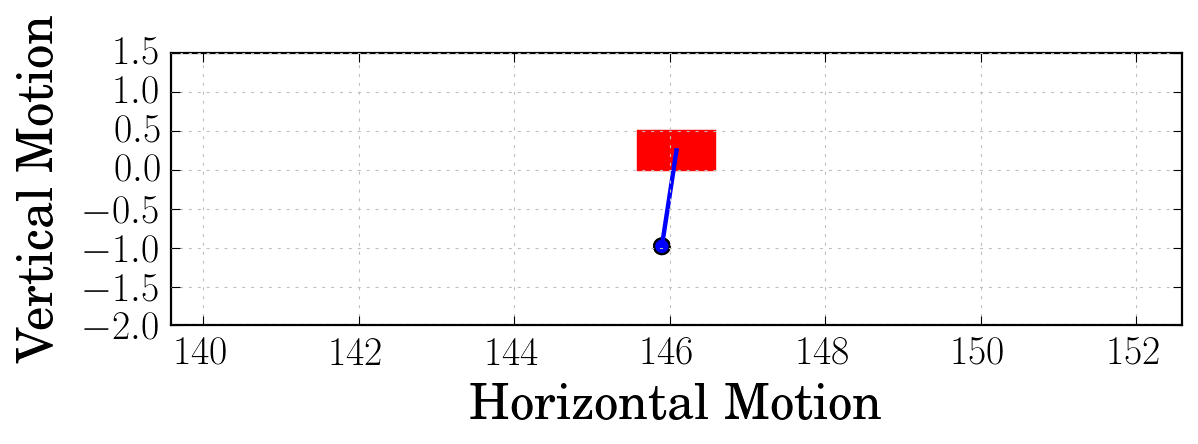

In [9]:
x_ani=resp[:,0]
pen_x = x_ani + Pen_length*np.sin(resp[:,1])
pen_y = Pen_length*np.cos(resp[:,1])
cart_width = 1
cart_height = 0.5
x_max_movie_index = np.where(sim_time>=10)[0][0]
x_max = max(x_ani[0:x_max_movie_index])

import matplotlib.animation as animation

# Change some plot properties to make the video work and look better
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Circle
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, aspect='equal')
plt.ylim(-Pen_length- 1, cart_height + 1)
# plt.xlim(-.2, np.max(x_ani) + cart_width+0.25)
# Uncomment to follow cart with camera
plt.xlim(x_ani[0]-6.0, x_ani[0]+cart_width+6.0)
plt.xlabel('Horizontal Motion', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Motion', fontsize=22, weight='bold', labelpad=10)


circle = plt.Circle((0, 0), 0.10, zorder = 0)
spring, = plt.plot([],[], linewidth=2, linestyle = '-', label='leftcable', 
                   color='b')
rect = patches.Rectangle((0, 0), 0, 0, angle=0, color='r')

def init():
    """ Initialize the lines in the plot """
    circle.center = (0, 0)
    spring.set_data([], [])
    ax.add_patch(circle)
    ax.add_patch(rect)
    return circle, spring, rect,

def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))

    circle.center=([pen_x[i]+ cart_width / 2, -pen_y[i]])
    spring.set_data([x_ani[i] + cart_width / 2, pen_x[i]+ cart_width / 2],
                    [cart_height / 2, -pen_y[i]])
    rect.set_width(cart_width)
    rect.set_height(cart_height)
    rect.set_xy([x_ani[i],0])
#     Uncomment to follow the cart with the camera
    plt.xlim(x_ani[i]-6.0, x_ani[i]+cart_width+6.0)
    return circle, spring, rect,

ani = animation.FuncAnimation(fig, animate_un, interval = 30, frames = 300,
                                 blit = True, init_func = init)

ani.save('/Users/forrest/Desktop/test.mp4', bitrate = 2500, fps = 30)